In [12]:
import os
import json
import random
from collections import Counter

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define paths
train_path = "train_test_split/train.json"
test_path = "train_test_split/test.json"

# Load the data
def load_data(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    texts = [item["text"] for item in data]
    intents = [item["intent"] for item in data]
    return texts, intents

# Load train and test data
X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

# Check initial intent distribution
intent_counts = Counter(y_train)
print("Initial Intent Distribution in Training Data:")
for intent, count in intent_counts.items():
    print(f"{intent}: {count}")


Initial Intent Distribution in Training Data:
flight: 3666
flight_time: 54
airfare: 423
aircraft: 81
ground_service: 255
airport: 20
airline: 157
distance: 20
abbreviation: 147
ground_fare: 18
quantity: 51
city: 19
flight_no: 12
capacity: 16
flight+airfare: 21
meal: 6
restriction: 6
airline+flight_no: 2
ground_service+ground_fare: 1
airfare+flight_time: 1
cheapest: 1
aircraft+flight+flight_no: 1


In [4]:
def balance_intent_data(X, y):
    """
    Perform oversampling to balance intent distribution.

    Args:
        X (list): List of input texts.
        y (list): List of corresponding intent labels.

    Returns:
        tuple: Balanced X and y.
    """
    intent_counts = Counter(y)
    max_count = max(intent_counts.values())  # Determine the maximum class size

    balanced_X, balanced_y = [], []
    intent_to_samples = {intent: [] for intent in intent_counts.keys()}

    # Group samples by intent
    for text, intent in zip(X, y):
        intent_to_samples[intent].append(text)

    # Oversample
    for intent, samples in intent_to_samples.items():
        num_samples = len(samples)
        oversample_count = max_count - num_samples
        if oversample_count > 0:
            samples = samples + random.choices(samples, k=oversample_count)  # Oversample
        balanced_X.extend(samples)
        balanced_y.extend([intent] * len(samples))

    return balanced_X, balanced_y

# Balance the training data
X_train_balanced, y_train_balanced = balance_intent_data(X_train, y_train)

# Save the balanced dataset as a separate file
balanced_train_path = "train_test_split/train_balanced.json"
balanced_train_data = [{"text": text, "intent": intent} for text, intent in zip(X_train_balanced, y_train_balanced)]
with open(balanced_train_path, "w", encoding="utf-8") as f:
    json.dump(balanced_train_data, f, indent=2, ensure_ascii=False)

print(f"Balanced training data saved to {balanced_train_path}")

# Check new intent distribution
balanced_counts = Counter(y_train_balanced)
print("\nBalanced Intent Distribution in Training Data:")
for intent, count in balanced_counts.items():
    print(f"{intent}: {count}")


Balanced training data saved to train_test_split/train_balanced.json

Balanced Intent Distribution in Training Data:
flight: 3666
flight_time: 3666
airfare: 3666
aircraft: 3666
ground_service: 3666
airport: 3666
airline: 3666
distance: 3666
abbreviation: 3666
ground_fare: 3666
quantity: 3666
city: 3666
flight_no: 3666
capacity: 3666
flight+airfare: 3666
meal: 3666
restriction: 3666
airline+flight_no: 3666
ground_service+ground_fare: 3666
airfare+flight_time: 3666
cheapest: 3666
aircraft+flight+flight_no: 3666



Overall Accuracy: 0.9306
Overall F1-Score: 0.9169

Classification Report (Balanced Training Data):
                   precision    recall  f1-score   support

     abbreviation       1.00      0.91      0.95        33
         aircraft       0.69      1.00      0.82         9
          airfare       0.84      0.90      0.87        48
   airfare+flight       0.00      0.00      0.00         1
          airline       1.00      0.89      0.94        38
          airport       0.93      0.78      0.85        18
         capacity       0.86      0.90      0.88        21
             city       1.00      0.50      0.67         6
         day_name       0.00      0.00      0.00         2
         distance       1.00      0.80      0.89        10
           flight       0.94      0.99      0.97       632
   flight+airfare       1.00      0.17      0.29        12
   flight+airline       0.00      0.00      0.00         1
        flight_no       1.00      0.25      0.40         8
flight_no+airl

C:\Users\erdem\PycharmProjects\cs411-pp3\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\erdem\PycharmProjects\cs411-pp3\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\erdem\PycharmProjects\cs411-pp3\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

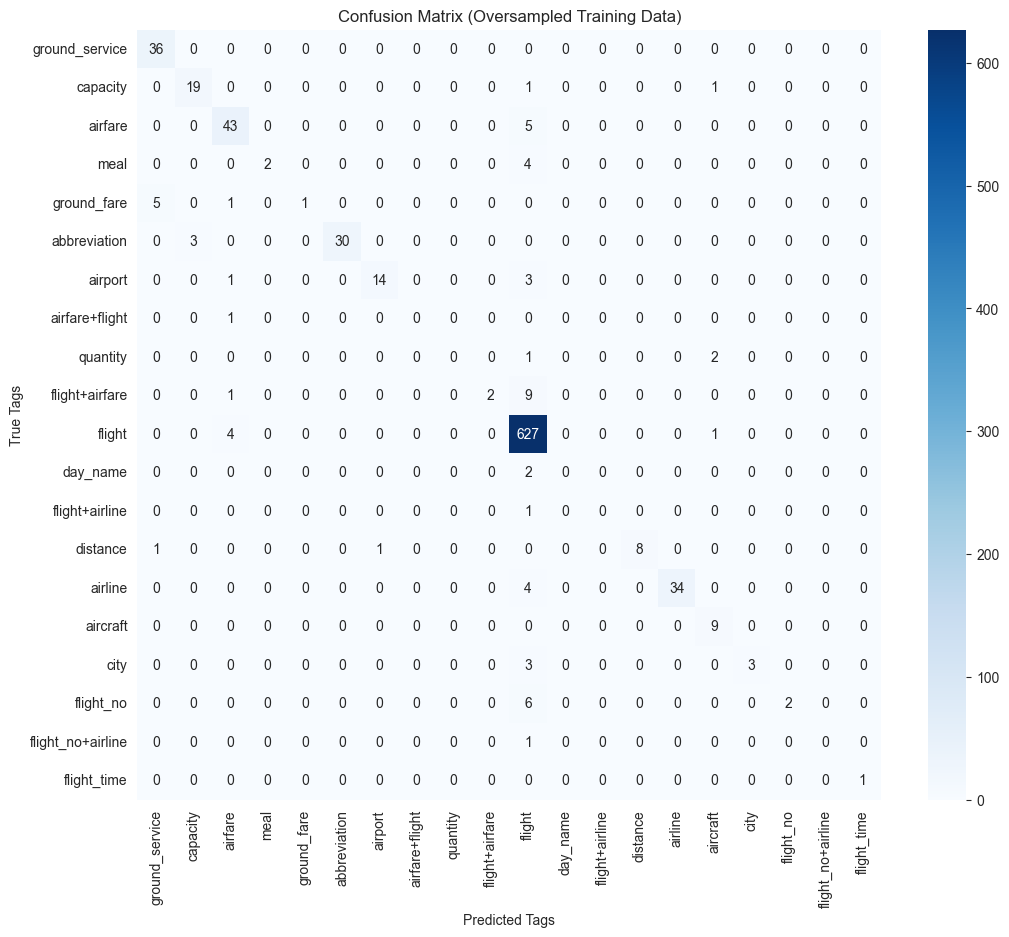

In [13]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")  # Using bigram
X_train_vectorized = tfidf.fit_transform(X_train_balanced)
X_test_vectorized = tfidf.transform(X_test)

# Train SVM
svm = LinearSVC()
svm.fit(X_train_vectorized, y_train_balanced)

# Test the model
y_pred = svm.predict(X_test_vectorized)

# Calculate and display overall accuracy and F1-Score
overall_accuracy = accuracy_score(y_test, y_pred)
overall_f1 = f1_score(y_test, y_pred, average="weighted")

print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")

# Evaluate the model
print("\nClassification Report (Balanced Training Data):")
print(classification_report(y_test, y_pred))

# Confusion Matrix for Oversampled Model
conf_matrix = confusion_matrix(y_test, y_pred, labels=list(set(y_test)))
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(set(y_test)), yticklabels=list(set(y_test)))
plt.xlabel('Predicted Tags')
plt.ylabel('True Tags')
plt.title('Confusion Matrix (Oversampled Training Data)')
plt.show()


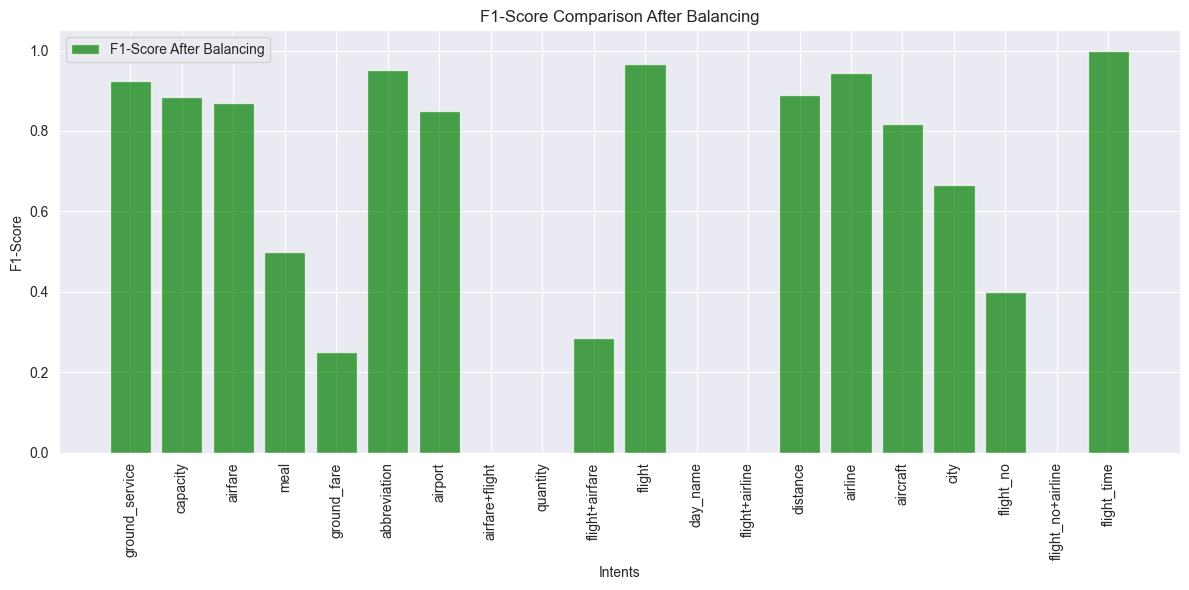

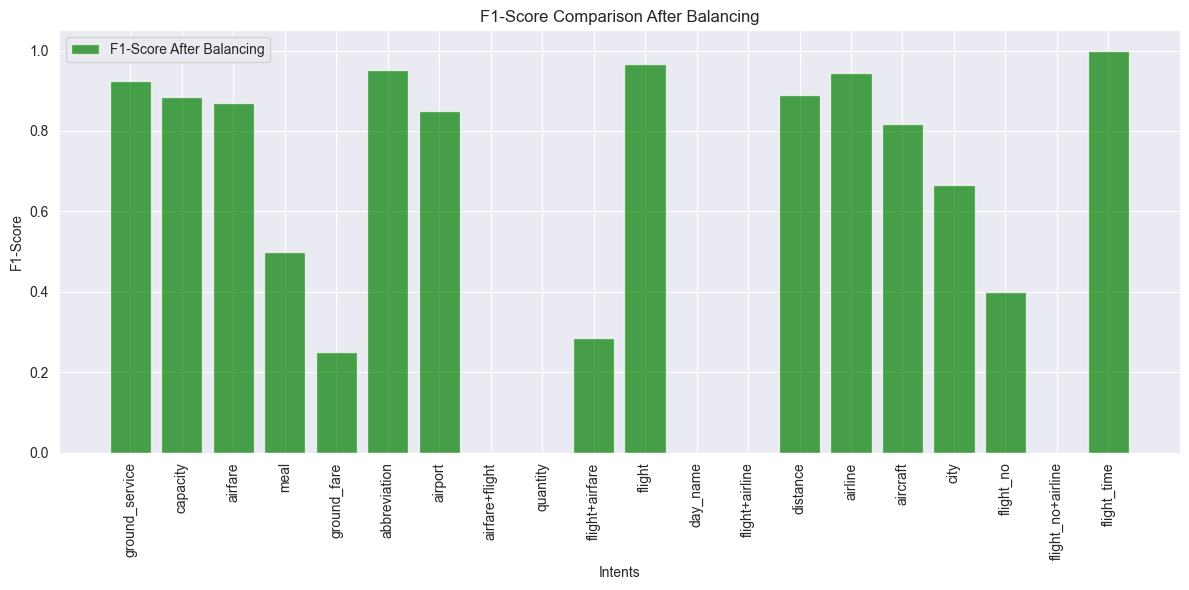

In [6]:
# Calculate F1-Score for each intent
intent_labels = list(set(y_test))
f1_scores = f1_score(y_test, y_pred, average=None, labels=intent_labels)

# Visualize F1-Scores
x = np.arange(len(intent_labels))
plt.figure(figsize=(12, 6))
plt.bar(x, f1_scores, color="green", alpha=0.7, label="F1-Score After Balancing")
plt.xticks(x, intent_labels, rotation=90)
plt.xlabel("Intents")
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison After Balancing")
plt.legend()
plt.tight_layout()
plt.show()
# Calculate F1-Score for each intent
intent_labels = list(set(y_test))
f1_scores = f1_score(y_test, y_pred, average=None, labels=intent_labels)

# Visualize F1-Scores
x = np.arange(len(intent_labels))
plt.figure(figsize=(12, 6))
plt.bar(x, f1_scores, color="green", alpha=0.7, label="F1-Score After Balancing")
plt.xticks(x, intent_labels, rotation=90)
plt.xlabel("Intents")
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison After Balancing")
plt.legend()
plt.tight_layout()
plt.show()
